In [5]:
from fairseq_utils import preprocess_series, load_dataset, load_model, get_embeddings
from fairseq.data import Dictionary
from constants import TOKENIZER_SUFFIXES, TOKENIZER_PATH, FAIRSEQ_PREPROCESS_PATH, PROJECT_PATH, PREDICTION_MODEL_PATH, TASK_PATH
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def embed_all(path, cuda=0):
    output_dict = dict()
    for model_type in ["roberta", 'bart']:
        tokenizer_dict = dict()
        for tokenizer_suffix in TOKENIZER_SUFFIXES:
            tokenizer_dict[tokenizer_suffix] = embed(path, model_type, tokenizer_suffix, cuda)
        output_dict[model_type] = tokenizer_dict 
    return output_dict

def embed(path, model_type, tokenizer_suffix, cuda):
    model_suffix = tokenizer_suffix+"_"+model_type
    fairseq_dict_path = TASK_PATH / "bbbp" /tokenizer_suffix
    model_path = PREDICTION_MODEL_PATH/model_suffix/"checkpoint_last.pt"
    model = load_model(model_path,fairseq_dict_path,str(cuda))
    dataset_path = (path / tokenizer_suffix/ "input0")
    dataset = load_dataset(dataset_path/"train")
    source_dictionary = Dictionary.load(str(dataset_path/"dict.txt"))
    embeddings = get_embeddings(model, dataset, source_dictionary, whole_mol=True, cuda=1)
    return embeddings

In [126]:
from rdkit import Chem

def canonize(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")
    return Chem.MolToSmiles(mol, canonical=True)
smiles_to_name_alkanes = {
    "CC": "Ethane",
    "CCC": "Propane",
    "CCCC": "Butane",
    "CC(C)C": "Isobutane",             # 2-methylpropane
    "CCCCC": "Pentane",
    "CC(C)CC": "Isopentane",             # 2-methylbutane
    "CC(C)(C)C": "Neopentane",           # 2,2-dimethylpropane
    "CCCCCC": "Hexane",
    "CCC(C)CC": "2-Methylpentane",
    "CC(C)CCC": "3-Methylpentane",
    "CC(C)(C)CC": "2,2-Dimethylbutane",
    "CC(C)C(C)C": "2,3-Dimethylbutane",
    "CCCCCCC": "Heptane",
    "CCCC(C)CC": "2-Methylhexane",
    "CCC(C)CCC": "3-Methylhexane",
    "CCC(C)(C)CC": "2,2-Dimethylpentane",
    "CCC(C)C(C)C": "2,3-Dimethylpentane",
    "CC(C)(C)CCC": "3,3-Dimethylpentane",
    "CC(C)CC(C)C": "2,4-Dimethylpentane",
    "CCC(CC)CC": "3-Ethylpentane",
    "CC(C)(C)C(C)C": "2,2,3-Trimethylbutane"
}
# Map friendly names to SMILES strings for readability
smiles_to_name_family1 = {
    'c1ccccc1': 'Benzene',
    'Cc1ccccc1': 'Toluene',
    'Fc1ccccc1': 'Fluorobenzene',
    'Clc1ccccc1': 'Chlorobenzene',
    'Brc1ccccc1': 'Bromobenzene',
    'Ic1ccccc1': 'Iodobenzene',
    'COc1ccccc1': 'Anisole',
    'Oc1ccccc1': 'Phenol',
    'Nc1ccccc1': 'Aniline',
    '[O-][N+](=O)c1ccccc1': 'Nitrobenzene',
    'N#Cc1ccccc1': 'Benzonitrile',
    'FC(F)(F)c1ccccc1': 'Trifluoromethylbenzene',
    'O=C(O)c1ccccc1': 'Benzoic acid',
    'NC(=O)c1ccccc1': 'Benzamide',
    'COC(=O)c1ccccc1': 'Methyl benzoate',
    'CC(=O)c1ccccc1': 'Acetophenone',
    'CCOc1ccccc1': 'Ethoxybenzene',
    'CC(C)c1ccccc1': 'Isopropylbenzene (Cumene)',
    'CC(Cl)c1ccccc1': 'Chlorotoluene',
}

smiles_to_name_family2 = {
    'CO': 'Methanol',
    'C=O': 'Formaldehyde',
    'O=CO': 'Formic acid',
    'CCO': 'Ethanol',
    'CC=O': 'Acetaldehyde',
    'CC(=O)O': 'Acetic acid',
    'CCCO': '1-Propanol',
    'CCC=O': 'Propanal',
    'CCC(=O)O': 'Propionic acid',
    'CCCCO': '1-Butanol',
    'CCCC=O': 'Butanal',
    'CCCC(=O)O': 'Butyric acid',
    'CC(C)O': 'Isopropanol',
    'CC(C)=O': 'Acetone',
    'CC(C)(C)O': 'tert-Butanol',
    "CC": "Ethane",
    "CCC": "Propane",
    "CCCC": "Butane",
    "CC(C)C": "Isobutane",             # 2-methylpropane
    "CCCCC": "Pentane",
    "CC(C)CC": "Isopentane",             # 2-methylbutane
    "CC(C)(C)C": "Neopentane",           # 2,2-dimethylpropane
    "CCCCCC": "Hexane",
}


expanded_smiles_to_name = {
    # Alkanes (n-alkanes and branched isomers)
    "C": "Methane",
    "CC": "Ethane",
    "CCC": "Propane",
    "CCCC": "Butane",
    "CC(C)C": "Isobutane",  # 2-methylpropane
    "CCCCC": "Pentane",
    "CC(C)CC": "Isopentane",  # 2-methylbutane
    "CC(C)(C)C": "Neopentane",  # 2,2-dimethylpropane
    "CCCCCC": "Hexane",
    "CC(C)CCC": "2-Methylpentane",
    "CC(C)C(C)C": "2,3-Dimethylbutane",
    "C(C)(C)CCC": "3-Methylpentane",
    "C(C)(C)C(C)C": "2,2-Dimethylbutane",
    "CCCCCCC": "Heptane",

    # Alcohols (-OH)
    'CO': 'Methanol',
    'CCO': 'Ethanol',
    'CCCO': '1-Propanol',
    'CC(O)C': '2-Propanol',  # Isopropanol (renamed for consistency)
    'CCCCO': '1-Butanol',
    'CC(O)CC': '2-Butanol',
    'CC(C)CO': 'Isobutanol',  # 2-methyl-1-propanol
    'CC(C)(C)O': 'tert-Butanol',
    'CCCCCO': '1-Pentanol',
    'CCCC(O)C': '2-Pentanol',
    'CCCCCCO': '1-Hexanol',
    'CCCCCCCCO': '1-Heptanol',
    
    # Aldehydes (-CHO)
    'C=O': 'Formaldehyde',
    'CC=O': 'Acetaldehyde',
    'CCC=O': 'Propanal',
    'CCCC=O': 'Butanal',
    'CCCCC=O': 'Pentanal',
    'CCCCCC=O': 'Hexanal',
    'CCCCCCC=O': 'Heptanal',

    # Ketones (R-C(=O)-R')
    'CC(C)=O': 'Acetone',
    'CCC(=O)C': '2-Butanone',
    'CC(=O)CC': '2-Butanone', # A common alternative SMILES
    'CCCC(=O)C': '2-Pentanone',
    'CC(=O)CCC': '2-Pentanone',
    'CCC(=O)CC': '3-Pentanone',

    # Carboxylic Acids (-COOH)
    'O=CO': 'Formic acid',
    'CC(=O)O': 'Acetic acid',
    'CCC(=O)O': 'Propionic acid',
    'CCCC(=O)O': 'Butyric acid',
    'CCCCC(=O)O': 'Valeric acid',
    'CCCCCC(=O)O': 'Hexanoic acid',
    'CCCCCCC(=O)O': 'Heptanoic acid',

    # Ethers (R-O-R')
    'COC': 'Dimethyl ether',
    'COCC': 'Ethyl methyl ether',
    'CCOCC': 'Diethyl ether',

    # Esters (R-C(=O)O-R')
    'O=C(O)C': 'Methyl formate',
    'O=C(O)CC': 'Ethyl formate',
    'CC(=O)OC': 'Methyl acetate',
    'CC(=O)OCC': 'Ethyl acetate',

    # Halogenated Hydrocarbons
    'CCl': 'Chloromethane',
    'C(Cl)Cl': 'Dichloromethane',
    'C(Cl)(Cl)Cl': 'Chloroform',
    'C(Cl)(Cl)(Cl)Cl': 'Carbon tetrachloride',
    'CCCl': 'Chloroethane',
    'CCCCl': '1-Chloropropane',
    'CC(Cl)C': '2-Chloropropane',
}

smiles_to_name_family3 = {
    'c1ccccc1': 'Benzene',
    'n1ccccc1': 'Pyridine',
    'Cc1ccccc1': 'Toluene',
    'Fc1ccccc1': 'Fluorobenzene',
    'FC1=CC=C(C)C=C1': 'Fluorotoluene',
    'Oc1ccccc1': 'Phenol',
    'COc1ccccc1': 'Anisole',
    'Nc1ccccc1': 'Aniline',
    '[O-][N+](=O)c1ccccc1': 'Nitrobenzene',
    'N(C)c1ccccc1': 'N-Methylaniline',
    'CC1=CC(=CC=C1)N': 'm-Toluidine',
    'CC1=CC(=CC=C1)O': 'm-Cresol',
    'CC(=O)c1ccccc1': 'Acetophenone',
    'CCOc1ccccc1': 'Ethoxybenzene',
    'CC(C)c1ccccc1': 'Isopropylbenzene (Cumene)',
}

smiles_to_name = expanded_smiles_to_name
molecule_smiles = [canonize(s) for s in smiles_to_name.keys()]
print(molecule_smiles)

['C', 'CC', 'CCC', 'CCCC', 'CC(C)C', 'CCCCC', 'CCC(C)C', 'CC(C)(C)C', 'CCCCCC', 'CCCC(C)C', 'CC(C)C(C)C', 'CCCC(C)C', 'CC(C)C(C)C', 'CCCCCCC', 'CO', 'CCO', 'CCCO', 'CC(C)O', 'CCCCO', 'CCC(C)O', 'CC(C)CO', 'CC(C)(C)O', 'CCCCCO', 'CCCC(C)O', 'CCCCCCO', 'CCCCCCCCO', 'C=O', 'CC=O', 'CCC=O', 'CCCC=O', 'CCCCC=O', 'CCCCCC=O', 'CCCCCCC=O', 'CC(C)=O', 'CCC(C)=O', 'CCC(C)=O', 'CCCC(C)=O', 'CCCC(C)=O', 'CCC(=O)CC', 'O=CO', 'CC(=O)O', 'CCC(=O)O', 'CCCC(=O)O', 'CCCCC(=O)O', 'CCCCCC(=O)O', 'CCCCCCC(=O)O', 'COC', 'CCOC', 'CCOCC', 'CC(=O)O', 'CCC(=O)O', 'COC(C)=O', 'CCOC(C)=O', 'CCl', 'ClCCl', 'ClC(Cl)Cl', 'ClC(Cl)(Cl)Cl', 'CCCl', 'CCCCl', 'CC(C)Cl']


In [127]:
latent_geometry_path = PROJECT_PATH/"latent_space_geometry"
preprocess_series(molecule_smiles, latent_geometry_path)

Tokenizing dataset: 100%|███████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 2459.26it/s]
2025-08-28 11:13:26 | INFO | fairseq_cli.preprocess | Namespace(no_progress_bar=False, log_interval=100, log_format=None, log_file=None, aim_repo=None, aim_run_hash=None, tensorboard_logdir=None, wandb_project=None, azureml_logging=False, seed=1, cpu=False, tpu=False, bf16=False, memory_efficient_bf16=False, fp16=False, memory_efficient_fp16=False, fp16_no_flatten_grads=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, on_cpu_convert_precision=False, min_loss_scale=0.0001, threshold_loss_scale=None, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, user_dir=None, empty_cache_freq=0, all_gather_list_size=16384, model_parallel_size=1, quantization_config_path=None, profile=False, reset_logging=False, suppress_crashes=False, use_plasma_view=False, plasma_path='/tmp/plasma', criterion='cross_entropy', tokeniz

In [128]:
embedding_dict = embed_all(latent_geometry_path, 1)

2025-08-28 11:13:50 | INFO | fairseq.file_utils | loading archive file /scratch/tlemmin/SoS/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_roberta
2025-08-28 11:13:50 | INFO | fairseq.file_utils | loading archive file /scratch/tlemmin/SoS/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2025-08-28 11:13:51 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-08-28 11:13:52 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001,

In [129]:
embeddings = embedding_dict['bart']['selfies_atom_standard']

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import matplotlib.offsetbox as offsetbox

from rdkit import Chem
from rdkit.Chem import Draw
#from rdkit.Chem.Draw import rdMolDraw2D, Draw
# --- RDKit and logging configuration ---
# We can suppress RDKit logs to keep the output clean.
import warnings
from rdkit import RDLogger
warnings.filterwarnings('ignore')
RDLogger.logger().setLevel(RDLogger.CRITICAL)
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
import io

import cairosvg


def svg_to_png_image(svg_str):
    """
    Convert an SVG string to a PIL Image.
    """
    png_bytes = cairosvg.svg2png(bytestring=svg_str.encode('utf-8'))
    return Image.open(io.BytesIO(png_bytes))

def mol_to_img_scaled(mol, size=(60, 60), bondLength=20):
    """
    Draw a molecule at a fixed visual scale (all molecules appear the same size)
    with a transparent background.
    """
    # Compute 2D coordinates
    Chem.rdDepictor.Compute2DCoords(mol)

    # Get atom coordinates
    conf = mol.GetConformer()
    coords = np.array([list(conf.GetAtomPosition(i))[:2] for i in range(mol.GetNumAtoms())])

    # Rescale coordinates to fit in a [0,1] x [0,1] box
    min_coords = coords.min(axis=0)
    max_coords = coords.max(axis=0)
    scale = max(max_coords - min_coords)
    coords_scaled = (coords - min_coords) / scale  # coordinates now in 0-1

    # Update the molecule's coordinates
    for i in range(mol.GetNumAtoms()):
        x, y = coords_scaled[i]
        conf.SetAtomPosition(i, Chem.rdGeometry.Point3D(x, y, 0))

    # Draw molecule using Cairo
    drawer = Draw.rdMolDraw2D.MolDraw2DCairo(size[0], size[1])
    drawer.drawOptions().bondLineWidth = 1.5
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()

    # Get PNG and convert to PIL image with transparency
    png_bytes = drawer.GetDrawingText()
    img = Image.open(io.BytesIO(png_bytes))
    if img.mode != 'RGBA':
        img = img.convert('RGBA')
    
    return img

# -----------------------------------------------------------------------------
# Function to plot 2D embeddings
# -----------------------------------------------------------------------------
def plot_2d_embeddings(embeddings_dict, method='UMAP', smiles=None):
    """
    Reduces the dimensionality of a set of embeddings and plots them in 2D.

    This function takes a dictionary of molecule names and their embeddings,
    performs dimensionality reduction using either PCA or UMAP, and then
    creates a scatter plot with labels for each molecule.

    Args:
        embeddings_dict (dict): A dictionary mapping molecule names (str)
                                to their embedding vectors (np.array).
        method (str): The dimensionality reduction method to use.
                      Options are 'PCA' or 'UMAP'. Default is 'UMAP'.
    """
    # Extract labels and embeddings from the dictionary
    labels = list(embeddings_dict.keys())
    embeddings = np.array(list(embeddings_dict.values()))

    # Choose the dimensionality reduction method
    if method == 'PCA':
        print("\nPerforming PCA for dimensionality reduction...")
        reducer = PCA(n_components=2)
        coords = reducer.fit_transform(embeddings)
    elif method == 'UMAP':
        print("\nPerforming UMAP for dimensionality reduction...")
        reducer = umap.UMAP(n_components=2, random_state=42)
        coords = reducer.fit_transform(embeddings)
    else:
        print(f"Invalid method: '{method}'. Defaulting to UMAP.")
        reducer = umap.UMAP(n_components=2, random_state=42)
        coords = reducer.fit_transform(embeddings)
    #print(coords)
    # Plot the 2D embeddings
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    ax.scatter(coords[:, 0], coords[:, 1], s=0)  # optional tiny points as placeholders

    for i, (s, c) in enumerate(zip(smiles, coords)):
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            # Draw molecule to PIL image
            img = Draw.MolToImage(mol, size=(60, 60), bondMin=2.0, bondMax=2.5)
            #im = offsetbox.OffsetImage(img, zoom=0.7)  # adjust zoom to scale image
            #svg_str = mol_to_svg_scaled(mol, size=(60, 60))
            # Convert SVG string to BytesIO for OffsetImage
            #img = svg_to_png_image(svg_str)
            
            # Convert image to OffsetImage
            im = offsetbox.OffsetImage(img, zoom=0.7)
            ab = offsetbox.AnnotationBbox(im, c, frameon=False)
            ax.add_artist(ab)
    
    # Add text labels for each point
    for i, label in enumerate(labels):
        plt.text(coords[i, 0] + 0.05, coords[i, 1] + 0.05, label, fontsize=9)

    plt.title(f"{method} Projection of Molecular Embeddings", fontsize=16)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

In [131]:
# The dictionary to be created
embeddings_dict = {}

# The requested code snippet
for i, name in enumerate(smiles_to_name.values()):
    embeddings_dict[name] = embeddings[i]
#plot_2d_embeddings(embeddings_dict, method='UMAP', smiles=molecule_smiles)

In [178]:
# --- 2. Define the Vector Operations ---
from numpy.linalg import norm
from sklearn.decomposition import PCA
import numpy as np


def fit_isotropy_transform(embeddings_dict, k=5, eps=1e-12):
    names = list(embeddings_dict.keys())
    X = np.stack([embeddings_dict[n] for n in names], axis=0).astype(np.float64)

    # Mean-center
    mu = X.mean(axis=0)
    Xc = X - mu

    # PCA via SVD
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    pcs = Vt[:k]  # top-k components

    # Build projector: remove top-k PCs
    P = np.eye(X.shape[1]) - pcs.T @ pcs

    def transform(v):
        v = v.astype(np.float64)
        v = v - mu
        v = v @ P
        n = np.linalg.norm(v)
        if n < eps:   # <-- safeguard
            return v * 0.0   # return a zero vector instead of NaN
        return v / n
    
    def simple_transform(v):
        v = v - mu
        n = np.linalg.norm(v)
        return v / (n + 1e-12)

    # Apply to all
    Xw = {n: ransform(embeddings_dict[n]) for n in names}
    return Xw


def normalize_reduce_embeddings(embeddings_dict, n_components=20, method="umap"):
    """
    Normalize and optionally reduce dimensionality of embeddings for analogy experiments.

    Args:
        embeddings_dict (dict): {molecule_name: embedding (np.array)}
        n_components (int): Number of dimensions to keep
        method (str): "pca", "umap", or "none"

    Returns:
        reduced_dict (dict): New dictionary with reduced + normalized embeddings
        reducer (object or None): Fitted PCA/UMAP object (None if method="none")
    """
    # --- Stack into matrix ---
    names = list(embeddings_dict.keys())
    X = np.stack([embeddings_dict[n] for n in names], axis=0).astype(np.float64)

    reducer = None

    if method == "pca":
        reducer = PCA(n_components=n_components, svd_solver="auto", random_state=42)
        X_reduced = reducer.fit_transform(X)

    elif method == "umap":
        if umap is None:
            raise ImportError("umap-learn is not installed. Please install with `pip install umap-learn`.")
        reducer = umap.UMAP(n_components=n_components, random_state=42)
        X_reduced = reducer.fit_transform(X)

    elif method == "none":
        X_reduced = X  # keep raw embeddings

    else:
        raise ValueError("method must be one of: 'pca', 'umap', 'none'")

    # --- L2 normalization ---
    norms = np.linalg.norm(X_reduced, axis=1, keepdims=True) + 1e-12
    print("Min norm:", float(norms.min()), "Max norm:", float(norms.max()))
    #X_norm = X_reduced / norms
    X_norm = X_reduced
    # --- Back to dictionary ---
    reduced_dict = {name: vec for name, vec in zip(names, X_norm)}

    return reduced_dict, reducer

# --- Isotropy Adjustment ---
def isotropy_adjust(embeddings_dict, remove_topk=0):
    """
    embeddings: np.array (n_samples, dim)
    remove_topk: how many top principal components to remove
    """
    names = list(embeddings_dict.keys())
    embeddings = np.stack([embeddings_dict[n] for n in names], axis=0).astype(np.float64)
    # 1. Center embeddings
    mean_vec = np.mean(embeddings, axis=0, keepdims=True)
    X = embeddings - mean_vec
    
    # 2. Optionally remove top principal components
    if remove_topk > 0:
        pca = PCA(n_components=remove_topk)
        pca.fit(X)
        pcs = pca.components_
        X = X - X @ pcs.T @ pcs
    
    # 3. Normalize (optional, but common)
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    adjust_dict = {name: vec for name, vec in zip(names, X)}
    return adjust_dict


# --- Whitening ---
def whitening(embeddings_dict, n_components=None):
    """
    PCA whitening of embeddings
    embeddings: np.array (n_samples, dim)
    n_components: how many PCA components to keep (None = keep all)
    """
    names = list(embeddings_dict.keys())
    embeddings = np.stack([embeddings_dict[n] for n in names], axis=0).astype(np.float64)
    # Center embeddings
    mean_vec = np.mean(embeddings, axis=0, keepdims=True)
    X = embeddings - mean_vec
    
    # PCA decomposition
    pca = PCA(n_components=n_components, whiten=True)
    X_whitened = pca.fit_transform(X)
    
    # Optional: normalize again
    X_whitened = X_whitened / np.linalg.norm(X_whitened, axis=1, keepdims=True)
    adjust_dict = {name: vec for name, vec in zip(names, X_whitened)}
    return adjust_dict

def perform_vector_operations(embeddings_dict, operations):
    """
    Performs specific vector operations on the embeddings and finds the
    closest match within the dataset.

    Args:
        embedding_dict (dict): A dictionary mapping molecule names to embedding vectors.
    """
    #whitened,pca = normalize_reduce_embeddings(embeddings_dict, 2, 'none')   
    #whitened = embeddings_dict
    for mol_a, mol_b, mol_c, expected_result in operations:
        try:
            embed_a = embeddings_dict[mol_a]
            embed_b = embeddings_dict[mol_b]
            embed_c = embeddings_dict[mol_c]

            # The vector operation
            target_vector = embed_a - embed_b + embed_c
            print(f"\nPerforming vector operation: '{mol_a}' - '{mol_b}' + '{mol_c}'")

            # Initialize with a very low similarity score
            max_similarity = -1
            closest_match_name = None

            for current_name, current_embedding in embeddings_dict.items():
                # Cosine Similarity Formula: A ? B / (||A|| * ||B||)
                #if current_name in [mol_a, mol_b, mol_c]:
                #    continue
                #similarity = cosine_similarity(target_vector, current_embedding)
                similarity = np.dot(target_vector, current_embedding) / (norm(target_vector) * norm(current_embedding))
                if similarity > 0.5:
                    print(f'{current_name} similarity: {similarity} ')
                if similarity > max_similarity:
                    max_similarity = similarity
                    closest_match_name = current_name
                    similarity_c = np.dot(embed_c, current_embedding) / (norm(embed_c) * norm(current_embedding))
                    similarity_t = np.dot(target_vector, embed_c) / (norm(target_vector) * norm(embed_c))
                    #if current_name in [mol_a, mol_b, mol_c]:
                    if current_name in [mol_c]:
                        max_s = 0
                        for cn,ce in embeddings_dict.items():
                            if cn in [current_name]:
                                #print(f'Skipping {cn}')
                                continue
                            s = np.dot(ce, current_embedding) / (norm(ce) * norm(current_embedding))
                            if s > max_s:
                                #print(f"{cn} :: {s}")
                                closest = cn
                                max_s = s
                        #print(f"Searching for closest :: {current_name} :: Closest found :: {closest}")
            print(f"  Closest match found: '{closest_match_name}'")
            print(f"  Highest similarity score: {max_similarity:.4f}")
            print(f"  Expected result: '{expected_result}' -> {'Match!' if closest_match_name == expected_result else 'Mismatch'}")
            print(f"  Similarity to Vec C: '{similarity_c} :: {similarity_t} ")
            print(f"  Similarity to Vec C: '{closest}' :: {max_s} ")


        except KeyError as e:
            print(f"Error: One of the molecules was not found in the dictionary: {e}")




Performing UMAP for dimensionality reduction...


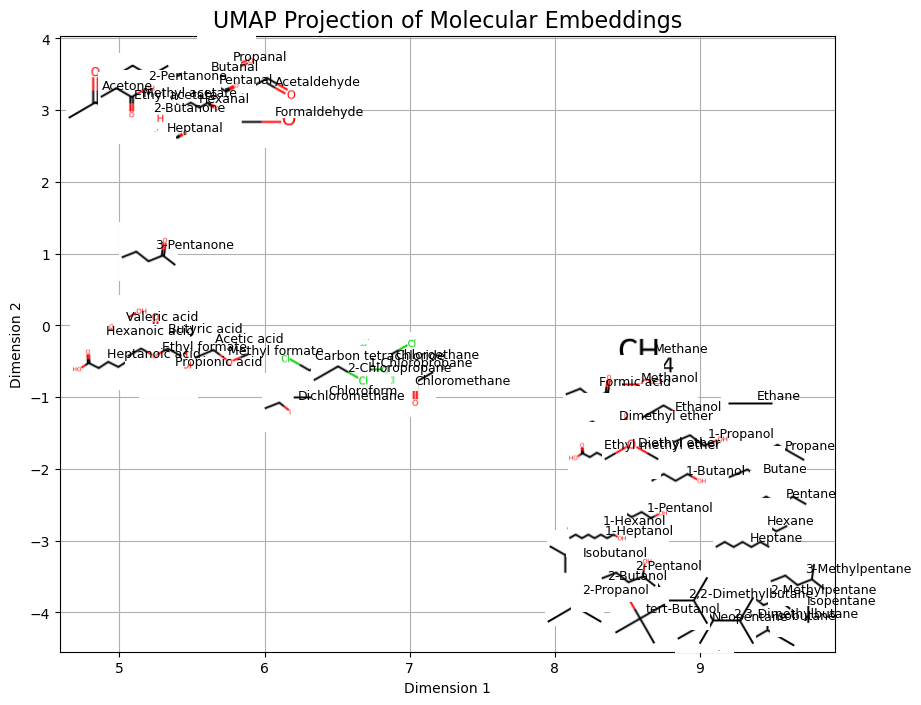

In [286]:
#normed_dict = whitening(embeddings_dict, n_components=4)
#remove first PC:
#All-but-the-Top: Simple and Effective Postprocessing for Word Representations
#https://arxiv.org/abs/1702.01417
normed_dict = isotropy_adjust(embeddings_dict, remove_topk=1)
plot_2d_embeddings(normed_dict, method='UMAP', smiles=molecule_smiles)

In [275]:
    # Define operations where the result is a molecule that exists in the dataset.
alkane_operations = [
    # Chain growth (add one CH2)
    ("Butane", "Propane", "Propane", "Butane"),
    ("Butane", "Propane", "Butane", "Pentane"),
    ("Butane", "Propane", "Pentane", "Hexane"),
    ("Pentane", "Butane", "Hexane", "Heptane"),

    # Branch-transfer / branching analogies
    ("Isobutane", "Butane", "Pentane", "Isopentane"),
    ("Isobutane", "Butane", "Hexane", "2-Methylpentane"),
    ("Isopentane", "Pentane", "Hexane", "2-Methylpentane"),
    ("Neopentane", "Pentane", "Hexane", "2,2-Dimethylbutane"),
    ("2-Methylpentane", "Hexane", "Heptane", "2-Methylhexane"),
    ("3-Methylpentane", "Hexane", "Heptane", "3-Methylhexane"),
    ("2,2-Dimethylbutane", "Hexane", "Heptane", "2,2-Dimethylpentane"),
    ("2,3-Dimethylbutane", "Hexane", "Heptane", "2,3-Dimethylpentane"),

    # Isomerization / reverse-transfer checks
    ("Isopentane", "Pentane", "Isobutane", "Butane"),
    ("2-Methylpentane", "Hexane", "Isopentane", "Pentane"),
    ("3-Methylpentane", "Hexane", "Isopentane", "Pentane"),
]

operations_family1 = [
    # Basic operator transfer: H?CH3, H?X, H?OCH3, etc.
    ('Toluene', 'Benzene', 'Phenol', 'Anisole'),                     # add CH3 where OH was ? O-methyl analogue
    ('Fluorobenzene', 'Benzene', 'Toluene', 'Fluorotoluene'),        # add F and CH3 together
    ('Chlorobenzene', 'Benzene', 'Toluene', 'Chlorotoluene'),        # user-style op: add CH3 to chloro
    ('Bromobenzene', 'Benzene', 'Toluene', 'Isopropylbenzene (Cumene)'), # Br vs iPr is not exact MMP, but good stress test

    ('Anisole', 'Phenol', 'Aniline', 'N-Methylaniline'),             # O-methyl vs N-methyl transfer
    ('Benzoic acid', 'Benzene', 'Toluene', 'Acetophenone'),          # rough ?+CO? transfer test (CH3?COCH3)

    ('Benzonitrile', 'Benzene', 'Toluene', 'Trifluoromethylbenzene'),# EWG/EWGs operator stress (not strict MMP)
    ('Nitrobenzene', 'Benzene', 'Aniline', 'Benzamide'),             # NO2 vs NH2 toward amide via ?+C=O? flavor (probe)

    # Consistency checks across halogens (H?F ? apply to CH3-substituted ring)
    ('Fluorobenzene', 'Chlorobenzene', 'Bromobenzene', 'Iodobenzene'),  # halogen ladder

    # Inverse-style checks (remove methyl)
    ('Benzene', 'Toluene', 'Chlorotoluene', 'Chlorobenzene'),        # remove CH3 from chlorotoluene
    ('Benzene', 'Toluene', 'Isopropylbenzene (Cumene)', 'Bromobenzene'), # stress: not exact MMP, probing geometry

    # Alkoxy shift
    ('Ethoxybenzene', 'Toluene', 'Phenol', 'Anisole'),               # ethoxy ? methyl + OH ? methoxy
    ('Anisole', 'Toluene', 'Ethoxybenzene', 'Ethoxybenzene'),        # sanity: methoxy vs ethoxy alignment

    # Acid/amide/ester consistency
    ('Methyl benzoate', 'Benzoic acid', 'Benzamide', 'Benzamide'),   # ester/acid/amide triangle check
]
 
    
operations_family2_old = [
    # Homologation (chain-length operator): (C2 ? C1 + C3 ? C4)
    ('Ethanol', 'Methanol', '1-Propanol', '1-Butanol'),
    ('1-Propanol', 'Ethanol', 'Propanal', 'Butanal'),
    ('Acetaldehyde', 'Formaldehyde', 'Propanal', 'Butanal'),
    ('Acetic acid', 'Formic acid', 'Propionic acid', 'Butyric acid'),

    # Cross-functional operator transfer: Aldehyde ? Alcohol + other Alcohol ? matching Aldehyde
    ('Acetaldehyde', 'Ethanol', '1-Propanol', 'Propanal'),
    ('1-Propanol', 'Propane', 'Butane', '1-Butanol'),
    ('Butanal', '1-Butanol', 'Ethane', 'Acetaldehyde'),

    # Acid ? Aldehyde + other Aldehyde ? matching Acid
    ('Acetic acid', 'Acetaldehyde', 'Propanal', 'Propionic acid'),
    ('Propionic acid', 'Propanal', 'Butane', '1-Butanol'),
    ('Propionic acid', 'Propanal', 'Acetaldehyde', 'Acetic acid'),

    # Ketone/alcohol consistency in the branched set
    ('Acetone', 'Isopropanol', 'Ethanol', 'Acetaldehyde'),  # secondary ? primary pattern stress test
    ('Isopropanol', 'Ethanol', 'Acetaldehyde', 'Acetone'),  # inverse mapping

    # Simple oxidation/reduction style (approximate operator reuse)
    ('Formic acid', 'Formaldehyde', 'Acetaldehyde', 'Acetic acid'),
    ('Acetic acid', 'Acetaldehyde', 'Formaldehyde', 'Formic acid'),
]

operations_family2 = [
    # 1. Homologation: The vector for adding a single -CH2- group
    # to the carbon chain, extending its length.
        ('Propane', 'Ethane', 'Butane', 'Pentane'),
        ('Butane', 'Propane', 'Pentane', 'Hexane'),
    
        ('Ethanol', 'Methanol', '1-Propanol', '1-Butanol'),
        ('Acetic acid', 'Formic acid', 'Propionic acid', 'Butyric acid'),
# Branchine
        ('Isobutane', 'Butane', 'Pentane', 'Isopentane'),
        ('Isobutane', 'Butane', 'Isopentane', 'Neopentane'),

    # 2. Oxidation/Reduction: The vector for converting a functional
    # group, e.g., from an alcohol to an aldehyde or from an aldehyde to an acid.
('Acetic acid', 'Acetaldehyde', 'Propanal', 'Propionic acid'),
('Acetaldehyde','Acetic acid',  'Propionic acid', 'Propanal'),
        # Aldehyde -> Carboxylic Acid
('Acetic acid', 'Acetaldehyde', 'Butanal', 'Butyric acid'),

        # Alcohol -> Aldehyde
#('Formaldehyde', 'Methanol', 'Ethanol', 'Acetaldehyde'),
#    ('Propionic acid', 'Propanal', 'Butane', '1-Butanol'),
        # Ketone/Alcohol relationship
        #('Acetone', 'Isopropanol', 'Acetaldehyde', 'Ethanol'),


        

    ]

expanded_operations_2 = [
    # 1. Chain elongation
    ("Propane", "Ethane", "Butane", "Pentane"),        # +CH2 homologation
    ("Butane", "Propane", "Pentane", "Hexane"),
    ("Pentane", "Butane", "Hexane", "Heptane"),
    ("Ethanol", "Methanol", "Propanol", "Butanol"),    # alcohol homologation
    ("Propanal", "Ethanol", "Butanal", "Propanol"),    # aldehyde vs alcohol chain growth]

    # 2.
    ("Ethanol", "Ethane", "Propane", "Propanol"),      # Alkane ? Alcohol analogy
    ("Propanal", "Ethanol", "Butanal", "Propanol"),    # Alcohol ? Aldehyde shift
    ("Acetone", "Ethanol", "2-Butanone", "Propanol"),  # Alcohol ? Ketone
    ("Acetic acid", "Ethanol", "Propionic acid", "Propanol"), # Alcohol ? Acid

    # 3. 
    ("Ethanol", "Ethane", "Propane", "Propanol"),      # Alkane ? Alcohol analogy
    ("Propanal", "Ethanol", "Butanal", "Propanol"),    # Alcohol ? Aldehyde shift
    ("Acetone", "Ethanol", "2-Butanone", "Propanol"),  # Alcohol ? Ketone
    ("Acetic acid", "Ethanol", "Propionic acid", "Propanol"), # Alcohol ? Acid

    # 4.
    ("Butane", "Propane", "Isobutane", "Isopropanol"), # branching preserved across FG change
    ("Pentane", "Butane", "Isopentane", "Isobutane"),  # linear ? branched shift
    ("Pentane", "Butane", "Neopentane", "Isobutane"),  # higher branching shift

    # 5. 
    # Substitute -OH -> -Cl on same carbon count (define v_{Cl?OH} = Chloromethane - Methanol)
#    ("Chloromethane", "Methanol", "Ethanol", "Chloroethane"),
    ("Chloromethane", "Methanol", "1-Propanol", "1-Chloropropane"),
    ("Chloromethane", "Methanol", "2-Propanol", "2-Chloropropane"),

    # Cross-check: +Cl from ethane applied to propanol carbon skeletons
    #("Chloroethane", "Ethanol", "1-Propanol", "1-Chloropropane"),
    #("Chloroethane", "Ethanol", "2-Propanol", "2-Chloropropane"),
]

    

expanded_operations = [
    # 1. Homologation: Vector for adding a -CH2- group
    ('Propane', 'Ethane', 'Butane', 'Pentane'),
    
    ('Butane', 'Propane', 'Pentane', 'Hexane'),
    #('Propane', 'Ethane', 'Hexane', 'Heptane'),
    
    # Homologation in derivatives
    ('Ethanol', 'Methanol', '1-Propanol', '1-Butanol'),
    ('1-Propanol', 'Ethanol', '1-Butanol', '1-Pentanol'),
    ('Acetic acid', 'Formic acid', 'Propionic acid', 'Butyric acid'),
    ('Propionic acid', 'Acetic acid', 'Butyric acid', 'Valeric acid'),
    ('Acetaldehyde', 'Formaldehyde', 'Propanal', 'Butanal'),
    ('Propanal', 'Acetaldehyde', 'Butanal', 'Pentanal'),

    # 2. Branching: Vector for adding a side chain (e.g., -CH3)
    ('Isobutane', 'Butane', 'Pentane', 'Isopentane'),
    ('Isobutane', 'Butane', 'Isopentane', 'Neopentane'),
    ('2-Methylpentane', 'Hexane', 'Heptane', '3-Methylpentane'),
    ('Isobutanol', '1-Butanol', '1-Pentanol', '2-Pentanol'),
    
    # 3. Oxidation/Reduction: Vector for converting functional groups
    # Aldehyde -> Carboxylic Acid
    ('Acetic acid', 'Acetaldehyde', 'Butanal', 'Butyric acid'),
    ('Propionic acid', 'Propanal', 'Pentanal', 'Valeric acid'),
    
    # Alcohol -> Aldehyde
    ('Acetaldehyde', 'Ethanol', 'Propanal', '1-Propanol'),
    ('Butanal', '1-Butanol', 'Pentanal', '1-Pentanol'),
        ('Propane', 'Ethane', 'Butane', 'Pentane'),
        ('Butane', 'Propane', 'Pentane', 'Hexane'),
    
        ('Ethanol', 'Methanol', '1-Propanol', '1-Butanol'),
        ('Acetic acid', 'Formic acid', 'Propionic acid', 'Butyric acid'),
# Branchine
        ('Isobutane', 'Butane', 'Pentane', 'Isopentane'),
        ('Isobutane', 'Butane', 'Isopentane', 'Neopentane'),

    # 2. Oxidation/Reduction: The vector for converting a functional
    # group, e.g., from an alcohol to an aldehyde or from an aldehyde to an acid.
('Acetic acid', 'Acetaldehyde', 'Propanal', 'Propionic acid'),
('Acetaldehyde','Acetic acid',  'Propionic acid', 'Propanal'),
        # Aldehyde -> Carboxylic Acid
('Acetic acid', 'Acetaldehyde', 'Butanal', 'Butyric acid'),

    # Aldehyde -> Alcohol (Reduction)
    #('Ethanol', 'Acetaldehyde', '1-Propanol', 'Propanal'),
    #('1-Butanol', 'Butanal', '1-Pentanol', 'Pentanal'),

    # Alcohol -> Ketone (Oxidation of secondary alcohol)
    #('Acetone', '2-Propanol', '2-Butanone', '2-Butanol'),
    #('2-Butanone', '2-Butanol', '2-Pentanone', '2-Pentanol'),

    # 4. Functional Group Swapping
    # Alcohol -> Ketone (Oxidation)
    ('2-Propanol', 'Acetone', 'Acetaldehyde', 'Ethanol'),
    # Note: This is an interesting but potentially challenging operation as the
    # vector represents two simultaneous transformations.
    
    # Chlorine substitution
    ('Chloromethane', 'Methanol', '1-Propanol', '1-Chloropropane'),
    ('Chloromethane', 'Methanol', '2-Propanol', '2-Chloropropane'),
    ('Chloromethane', 'Methane', '1-Propane', '1-Chloropropane'),

    # 5. Ethers
    ('Dimethyl ether', 'Methanol', 'Ethyl methyl ether', 'Ethanol'),
]

operations_family3 = [
    # Your originals (kept consistent)
    ('Toluene', 'Benzene', 'Aniline', 'm-Toluidine'),
    ('Phenol', 'Benzene', 'Toluene', 'm-Cresol'),

    # Halogen/methyl transfer checks
    ('Fluorotoluene', 'Toluene', 'Benzene', 'Fluorobenzene'),
    ('Fluorobenzene', 'Benzene', 'Toluene', 'Fluorotoluene'),

    # O-methyl ? N-methyl transfer
    ('Anisole', 'Phenol', 'Aniline', 'N-Methylaniline'),
    ('N-Methylaniline', 'Aniline', 'Phenol', 'Anisole'),

    # Carbonyl vs alkyl operator stress (acetyl vs methyl)
    ('Acetophenone', 'Toluene', 'Benzene', 'Benzene'),   # sanity check: removing +CH3 part of acetyl is not exact, acts as control
    ('Acetophenone', 'Benzene', 'Toluene', 'Isopropylbenzene (Cumene)'),  # stress: probes if ?+CO? behaves like +CH3 extension (likely negative)

    # Alkoxy extension transfer
    ('Ethoxybenzene', 'Toluene', 'Phenol', 'Anisole'),
    ('Anisole', 'Phenol', 'Toluene', 'Fluorotoluene'),   # stress: O-methyl vs ring CH3 analog (expect imperfect)

    # Nitro ? amino polarity flip as operator
    ('Nitrobenzene', 'Benzene', 'Aniline', 'Acetophenone'),  # strong EWG ? basic amino; follow-up carbonyl check (control)
    ('Aniline', 'Benzene', 'Nitrobenzene', 'Benzamide'),     # amino ? nitro then amide (tests EWG/EWD operator composition)
]


In [276]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from typing import Dict, List, Tuple

def check_and_filter_non_trivial_operations(
    operations: List[Tuple[str, str, str, str]],
    embeddings_dict: Dict[str, Dict[str, np.ndarray]],
    smiles_to_name: Dict[str, str],
    models: List[Tuple[str, str]],
    magnitude_threshold: float = 1e-6
) -> Dict[str, List]:
    """
    Checks operations for triviality across all models and returns a comprehensive
    dictionary detailing the results.

    The returned dictionary has two main keys:
    'non_trivial_operations': A list of operations that passed all checks for all models.
    'trivial_operations_breakdown': A dictionary showing which models/reasons caused
                                     an operation to be removed.

    Args:
        operations (List[Tuple[str, str, str, str]]): List of operations.
        embeddings_dict (Dict[str, Dict[str, np.ndarray]]): Embeddings data.
        smiles_to_name (Dict[str, str]): SMILES to name mapping.
        models (List[Tuple[str, str]]): List of model/representation pairs.
        magnitude_threshold (float): L2 norm threshold for "insignificant difference".

    Returns:
        Dict[str, List]: A dictionary containing the filtered operations and
                        the reasons for filtering.
    """
    non_trivial_operations = []
    trivial_operations_breakdown = {}

    for operation in operations:
        is_trivial_for_any_model = False
        reasons = {}
        mol_A, mol_B, mol_C, mol_D = operation

        for model_name, rep_name in models:
            model_key = f"{model_name}/{rep_name}"
            
            try:
                current_embeddings = embeddings_dict[model_name][rep_name]
                name_to_embedding = {name: current_embeddings[i] for i, name in enumerate(smiles_to_name.values())}

                emb_A = name_to_embedding[mol_A]
                emb_B = name_to_embedding[mol_B]
                emb_C = name_to_embedding[mol_C]
                emb_D = name_to_embedding[mol_D]
            except KeyError as e:
                if model_key not in reasons:
                    reasons[model_key] = []
                reasons[model_key].append(f"Missing molecule: {e}")
                is_trivial_for_any_model = True
                continue

            # Check 1: D's rank relative to A
            similarities_to_A = []
            for name, embedding in name_to_embedding.items():
                if name != mol_A:
                    sim = cosine_similarity(emb_A.reshape(1, -1), embedding.reshape(1, -1))[0][0]
                    similarities_to_A.append((name, sim))
            similarities_to_A.sort(key=lambda x: x[1], reverse=True)
            rank_D_to_A = next((i + 1 for i, (name, _) in enumerate(similarities_to_A) if name == mol_D), len(similarities_to_A) + 1)
            
            # Check 2: D's rank relative to C
            similarities_to_C = []
            for name, embedding in name_to_embedding.items():
                if name != mol_C:
                    sim = cosine_similarity(emb_C.reshape(1, -1), embedding.reshape(1, -1))[0][0]
                    similarities_to_C.append((name, sim))
            similarities_to_C.sort(key=lambda x: x[1], reverse=True)
            rank_D_to_C = next((i + 1 for i, (name, _) in enumerate(similarities_to_C) if name == mol_D), len(similarities_to_C) + 1)
            
            # Check 3: Insignificant difference vectors
            diff_AB = emb_A - emb_B
            diff_BC = emb_B - emb_C
            is_AB_insignificant = np.linalg.norm(diff_AB) < magnitude_threshold
            is_BC_insignificant = np.linalg.norm(diff_BC) < magnitude_threshold
            
            # If any condition makes the operation trivial, note the reason.
            if rank_D_to_A == 1:
                if model_key not in reasons: reasons[model_key] = []
                reasons[model_key].append("mol_D is a direct neighbor of mol_A (rank 1)")
                is_trivial_for_any_model = True
            if rank_D_to_C == 1:
                if model_key not in reasons: reasons[model_key] = []
                reasons[model_key].append("mol_D is a direct neighbor of mol_C (rank 1)")
                is_trivial_for_any_model = True
            if is_AB_insignificant:
                if model_key not in reasons: reasons[model_key] = []
                reasons[model_key].append("Vector A-B is insignificant")
                is_trivial_for_any_model = True
            if is_BC_insignificant:
                if model_key not in reasons: reasons[model_key] = []
                reasons[model_key].append("Vector B-C is insignificant")
                is_trivial_for_any_model = True
        
        if not is_trivial_for_any_model:
            non_trivial_operations.append(operation)
        else:
            trivial_operations_breakdown[operation] = reasons
    
    return {
        'non_trivial_operations': non_trivial_operations,
        'trivial_operations_breakdown': trivial_operations_breakdown
    }

In [277]:
operations = expanded_operations
models = [
    ('roberta', 'selfies_atom_standard'),
    ('roberta', 'smiles_atom_standard'),
    ('bart', 'selfies_atom_standard'),
    ('bart', 'smiles_atom_standard'),
]
# name_to_embedding = isotropy_adjust(name_to_embedding, remove_topk=0)
filtered_operations = check_and_filter_non_trivial_operations(operations, embedding_dict, smiles_to_name, models)

In [278]:
print(filtered_operations['non_trivial_operations'])

[('Acetic acid', 'Formic acid', 'Propionic acid', 'Butyric acid'), ('Isobutane', 'Butane', 'Isopentane', 'Neopentane'), ('Isobutanol', '1-Butanol', '1-Pentanol', '2-Pentanol'), ('Acetic acid', 'Acetaldehyde', 'Butanal', 'Butyric acid'), ('Propionic acid', 'Propanal', 'Pentanal', 'Valeric acid'), ('Acetaldehyde', 'Ethanol', 'Propanal', '1-Propanol'), ('Butanal', '1-Butanol', 'Pentanal', '1-Pentanol'), ('Acetic acid', 'Formic acid', 'Propionic acid', 'Butyric acid'), ('Isobutane', 'Butane', 'Isopentane', 'Neopentane'), ('Acetic acid', 'Acetaldehyde', 'Propanal', 'Propionic acid'), ('Acetic acid', 'Acetaldehyde', 'Butanal', 'Butyric acid'), ('2-Propanol', 'Acetone', 'Acetaldehyde', 'Ethanol'), ('Chloromethane', 'Methanol', '1-Propanol', '1-Chloropropane'), ('Chloromethane', 'Methanol', '2-Propanol', '2-Chloropropane'), ('Dimethyl ether', 'Methanol', 'Ethyl methyl ether', 'Ethanol')]


In [279]:
operations = filtered_operations['non_trivial_operations']
#perform_vector_operations(normed_dict, operations)
perform_vector_operations(embeddings_dict, operations)


Performing vector operation: 'Acetic acid' - 'Formic acid' + 'Propionic acid'
1-Propanol similarity: 0.6318045854568481 
2-Propanol similarity: 0.7097644805908203 
1-Butanol similarity: 0.6768752336502075 
2-Butanol similarity: 0.6211782693862915 
Isobutanol similarity: 0.6233359575271606 
tert-Butanol similarity: 0.589263379573822 
1-Pentanol similarity: 0.6477693319320679 
2-Pentanol similarity: 0.5696064829826355 
1-Hexanol similarity: 0.6098683476448059 
1-Heptanol similarity: 0.6130858063697815 
Butanal similarity: 0.5306815505027771 
Pentanal similarity: 0.5477270483970642 
Hexanal similarity: 0.5613619089126587 
Heptanal similarity: 0.5289085507392883 
Acetone similarity: 0.5278217196464539 
Acetic acid similarity: 0.8732179403305054 
Propionic acid similarity: 0.8681743144989014 
Butyric acid similarity: 0.8568063974380493 
Valeric acid similarity: 0.8354145884513855 
Hexanoic acid similarity: 0.8236740231513977 
Heptanoic acid similarity: 0.81778883934021 
Methyl formate simi

UnboundLocalError: local variable 'closest' referenced before assignment

In [280]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from typing import Dict, List, Tuple

def check_similarity_rank(
    operations: List[Tuple[str, str, str, str]],
    embeddings_dict: Dict[str, Dict[str, np.ndarray]],
    smiles_to_name: Dict[str, str],
    models: List[Tuple[str, str]]
) -> Dict[str, Dict[str, Dict[str, Dict[str, int]]]]:
    """
    Performs vector operations and calculates a comprehensive set of ranks to
    evaluate the significance of the results.

    The function returns:
    1. The rank of the solution_vector's similarity to mol_D.
    2. The rank of mol_D's similarity to mol_A.
    3. The rank of mol_D's similarity to mol_C.

    Args:
        operations (List[Tuple[str, str, str, str]]): A list of tuples, where
            each tuple represents an operation: (mol_A, mol_B, mol_C, mol_D)
            for the operation vector_A - vector_B + vector_C = vector_D.
        embeddings_dict (Dict[str, Dict[str, np.ndarray]]): A nested dictionary
            containing embeddings for different models and representations.
        smiles_to_name (Dict[str, str]): A dictionary mapping SMILES strings to
            molecule names.
        models (List[Tuple[str, str]]): A list of tuples, each defining a model
            and representation (e.g., ('roberta', 'selfies_atom_standard')).

    Returns:
        Dict[str, Dict[str, Dict[str, Dict[str, int]]]]: A nested dictionary
            containing the various ranks for each operation and model.
    """
    all_results = {}
    
    for model_name, rep_name in models:
        if model_name not in all_results:
            all_results[model_name] = {}
        all_results[model_name][rep_name] = {}
        
        current_embeddings = embeddings_dict[model_name][rep_name]
        
        name_to_embedding = {}
        for i, name in enumerate(smiles_to_name.values()):
            name_to_embedding[name] = current_embeddings[i]
        #name_to_embedding = isotropy_adjust(name_to_embedding, remove_topk=0)
        for operation in operations:
            mol_A, mol_B, mol_C, mol_D = operation
            op_key = f"{mol_A} - {mol_B} + {mol_C} = {mol_D}"
            all_results[model_name][rep_name][op_key] = {}

            try:
                emb_A = name_to_embedding[mol_A]
                emb_B = name_to_embedding[mol_B]
                emb_C = name_to_embedding[mol_C]
                emb_D = name_to_embedding[mol_D]
                solution_vector = emb_A - emb_B + emb_C
            except KeyError as e:
                print(f"Skipping operation '{op_key}' due to missing molecule: {e}")
                continue

            # --- Ranks based on Proximity to Target Molecule (D) ---
            similarities_to_D = []
            for name, embedding in name_to_embedding.items():
                if name == mol_D:
                    # Exclude self-comparison
                    continue
                similarity = cosine_similarity(
                    solution_vector.reshape(1, -1),
                    embedding.reshape(1, -1)
                )[0][0]

                similarities_to_D.append((name, similarity))
            
            # Also calculate the similarity of the solution vector to D
            solution_similarity_to_D = cosine_similarity(
                emb_D.reshape(1, -1),
                solution_vector.reshape(1, -1)
            )[0][0]
            
            #print(solution_similarity_to_D)
            # Sort all similarities (including the solution) by value in descending order
            similarities_to_D.sort(key=lambda x: x[1], reverse=True)
            #print(similarities_to_D)
            # Find the rank of the solution vector in this list
            rank_solution_to_D = 1
            for name, sim in similarities_to_D:
                if solution_similarity_to_D >= sim:
                    break
                rank_solution_to_D += 1
            
            all_results[model_name][rep_name][op_key]["rank_solution_to_D"] = rank_solution_to_D

            # --- Ranks based on Proximity to Source Molecules (A and C) ---
            
            # Rank of D relative to A
            similarities_to_A = []
            for name, embedding in name_to_embedding.items():
                if name != mol_A:
                    similarity = cosine_similarity(
                        emb_A.reshape(1, -1),
                        embedding.reshape(1, -1)
                    )[0][0]
                    similarities_to_A.append((name, similarity))
            
            similarities_to_A.sort(key=lambda x: x[1], reverse=True)
            
            rank_D_to_A = 1
            for name, _ in similarities_to_A:
                if name == mol_D:
                    break
                rank_D_to_A += 1
            all_results[model_name][rep_name][op_key]["rank_D_to_A"] = rank_D_to_A

            # Rank of D relative to C
            similarities_to_C = []
            for name, embedding in name_to_embedding.items():
                if name != mol_C:
                    similarity = cosine_similarity(
                        emb_C.reshape(1, -1),
                        embedding.reshape(1, -1)
                    )[0][0]
                    similarities_to_C.append((name, similarity))
            
            similarities_to_C.sort(key=lambda x: x[1], reverse=True)
            
            rank_D_to_C = 1
            for name, _ in similarities_to_C:
                if name == mol_D:
                    break
                rank_D_to_C += 1
            all_results[model_name][rep_name][op_key]["rank_D_to_C"] = rank_D_to_C
            
    return all_results

In [281]:
models = [
    ('roberta', 'selfies_atom_standard'),
    ('roberta', 'smiles_atom_standard'),
    ('bart', 'selfies_atom_standard'),
    ('bart', 'smiles_atom_standard'),
]
# name_to_embedding = isotropy_adjust(name_to_embedding, remove_topk=0)
all_results = check_similarity_rank(operations, embedding_dict, smiles_to_name, models)

In [282]:
all_results


{'roberta': {'selfies_atom_standard': {'Acetic acid - Formic acid + Propionic acid = Butyric acid': {'rank_solution_to_D': 6,
    'rank_D_to_A': 4,
    'rank_D_to_C': 4},
   'Isobutane - Butane + Isopentane = Neopentane': {'rank_solution_to_D': 3,
    'rank_D_to_A': 4,
    'rank_D_to_C': 4},
   'Isobutanol - 1-Butanol + 1-Pentanol = 2-Pentanol': {'rank_solution_to_D': 4,
    'rank_D_to_A': 3,
    'rank_D_to_C': 29},
   'Acetic acid - Acetaldehyde + Butanal = Butyric acid': {'rank_solution_to_D': 5,
    'rank_D_to_A': 4,
    'rank_D_to_C': 32},
   'Propionic acid - Propanal + Pentanal = Valeric acid': {'rank_solution_to_D': 4,
    'rank_D_to_A': 5,
    'rank_D_to_C': 19},
   'Acetaldehyde - Ethanol + Propanal = 1-Propanol': {'rank_solution_to_D': 54,
    'rank_D_to_A': 27,
    'rank_D_to_C': 30},
   'Butanal - 1-Butanol + Pentanal = 1-Pentanol': {'rank_solution_to_D': 50,
    'rank_D_to_A': 28,
    'rank_D_to_C': 14},
   'Acetic acid - Acetaldehyde + Propanal = Propionic acid': {'rank_s

In [283]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def evaluate_operations(operations, embeddings_dict, smiles_to_name, models):
    """
    operations: list of tuples (A, B, C, expected) in names
    embeddings: dict[model][rep][smiles] -> vector
    smiles_to_name: dict[smiles] -> name
    models: list of (model_key, rep_key)
    """
    rows = []
    smiles_inv = {v: k for k, v in smiles_to_name.items()}
    print(smiles_inv)
    for (a, b, c, expected) in operations:
        # find SMILES by name  
        sa, sb, sc, sexp = smiles_inv[a], smiles_inv[b], smiles_inv[c], smiles_inv[expected]

        # equation image
        eqn_mols = [Chem.MolFromSmiles(sa), Chem.MolFromSmiles(sb), Chem.MolFromSmiles(sc)]

        eqn_img = Draw.MolsToGridImage(eqn_mols, molsPerRow=3, subImgSize=(150,150), useSVG=False)

        row = {"Operation": eqn_img}

        for model_key, rep_key in models:
            embeddings = embeddings_dict[model_key][rep_key]
            # The dictionary to be created
            emb_dict = {}
            for i, name in enumerate(smiles_to_name.values()):
                emb_dict[name] = embeddings[i]
            #emb_dict = isotropy_adjust(emb_dict, remove_topk=0)
            va, vb, vc = emb_dict[a], emb_dict[b], emb_dict[c]

            query = va - vb + vc
            # nearest neighbor
            best_smiles, best_score = None, -1
            for smi, vec in emb_dict.items():
                if smi in [a, b, c]:
                    continue
                score = cosine_similarity(query, vec)
                if score > best_score:
                    best_score = score
                    best_smiles = smiles_inv[smi]

            best_mol = Chem.MolFromSmiles(best_smiles)
            img = Draw.MolToImage(best_mol, size=(150,150))

            # correctness check
            correct = (best_smiles == sexp)
            row[(model_key, rep_key)] = (img, best_score, correct)

        rows.append(row)

    return rows


In [284]:
from IPython.display import display, HTML
import base64
from io import BytesIO

from PIL import Image
from IPython.display import Image as IPyImage

def pil_to_html(img):
    """Convert a PIL.Image or IPython.display.Image to HTML <img> tag (base64)."""
    if isinstance(img, Image.Image):
        # Standard PIL
        buffer = BytesIO()
        img.save(buffer, format="PNG")
        data = base64.b64encode(buffer.getvalue()).decode("utf-8")
    elif isinstance(img, IPyImage):
        # Already an IPython.display.Image (RDKit sometimes returns this!)
        data = base64.b64encode(img.data).decode("utf-8")
    else:
        raise TypeError(f"Unsupported image type: {type(img)}")
    
    return f"<img src='data:image/png;base64,{data}'/>"

def display_results(rows, models):
    html = "<table border=1><tr><th>Operation</th>"
    for m in models:
        html += f"<th>{m[0]} + {m[1]}</th>"
    html += "</tr>"

    for row in rows:
        html += "<tr>"
        # operation image
        html += f"<td>{pil_to_html(row['Operation'])}</td>"
        for m in models:
            img, score, correct = row[m]
            border = "5px solid blue" if correct else "1px solid black"
            html += f"<td style='border:{border}; text-align:center'>"
            html += f"{pil_to_html(img)}<br>score={score:.2f}</td>"
        html += "</tr>"
    html += "</table>"

    display(HTML(html))


{'Methane': 'C', 'Ethane': 'CC', 'Propane': 'CCC', 'Butane': 'CCCC', 'Isobutane': 'CC(C)C', 'Pentane': 'CCCCC', 'Isopentane': 'CC(C)CC', 'Neopentane': 'CC(C)(C)C', 'Hexane': 'CCCCCC', '2-Methylpentane': 'CC(C)CCC', '2,3-Dimethylbutane': 'CC(C)C(C)C', '3-Methylpentane': 'C(C)(C)CCC', '2,2-Dimethylbutane': 'C(C)(C)C(C)C', 'Heptane': 'CCCCCCC', 'Methanol': 'CO', 'Ethanol': 'CCO', '1-Propanol': 'CCCO', '2-Propanol': 'CC(O)C', '1-Butanol': 'CCCCO', '2-Butanol': 'CC(O)CC', 'Isobutanol': 'CC(C)CO', 'tert-Butanol': 'CC(C)(C)O', '1-Pentanol': 'CCCCCO', '2-Pentanol': 'CCCC(O)C', '1-Hexanol': 'CCCCCCO', '1-Heptanol': 'CCCCCCCCO', 'Formaldehyde': 'C=O', 'Acetaldehyde': 'CC=O', 'Propanal': 'CCC=O', 'Butanal': 'CCCC=O', 'Pentanal': 'CCCCC=O', 'Hexanal': 'CCCCCC=O', 'Heptanal': 'CCCCCCC=O', 'Acetone': 'CC(C)=O', '2-Butanone': 'CC(=O)CC', '2-Pentanone': 'CC(=O)CCC', '3-Pentanone': 'CCC(=O)CC', 'Formic acid': 'O=CO', 'Acetic acid': 'CC(=O)O', 'Propionic acid': 'CCC(=O)O', 'Butyric acid': 'CCCC(=O)O', '

Operation,roberta + selfies_atom_standard,roberta + smiles_atom_standard,bart + selfies_atom_standard,bart + smiles_atom_standard
,score=0.87,score=0.85,score=0.87,score=0.87
,score=0.92,score=0.84,score=0.89,score=0.87
,score=0.97,score=0.87,score=0.93,score=0.89
,score=0.94,score=0.93,score=0.92,score=0.91
,score=0.95,score=0.96,score=0.94,score=0.93
,score=0.89,score=0.90,score=0.79,score=0.85
,score=0.92,score=0.88,score=0.85,score=0.85
,score=0.87,score=0.85,score=0.87,score=0.87
,score=0.92,score=0.84,score=0.89,score=0.87
,score=0.98,score=0.97,score=0.95,score=0.88

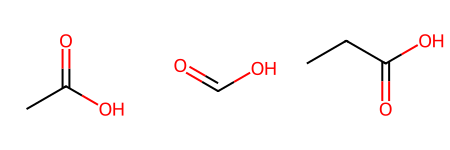
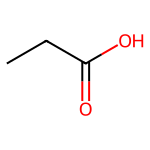
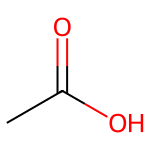
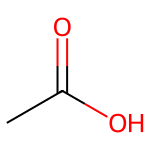
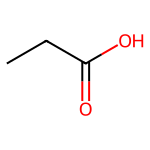
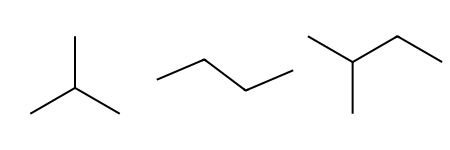
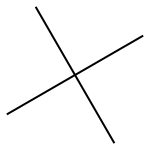
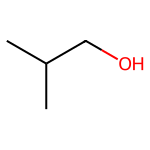
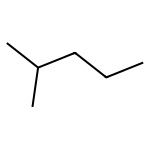
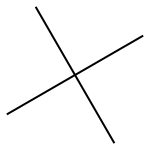
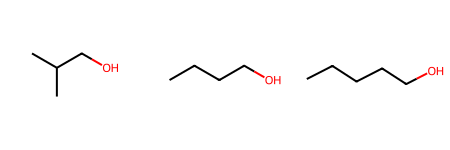
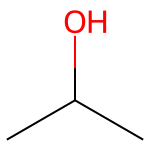
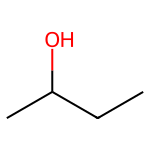
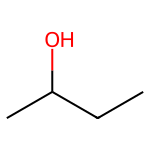
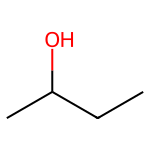
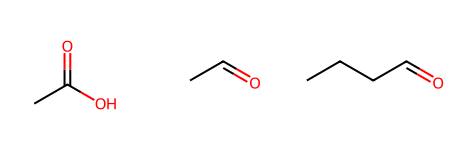
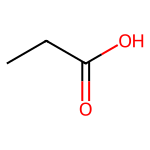
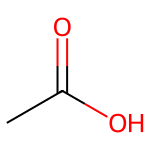
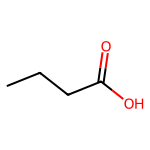
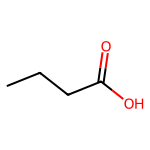
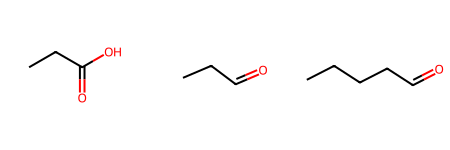
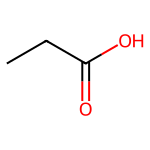
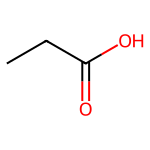
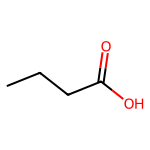
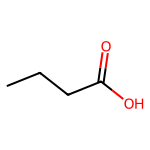
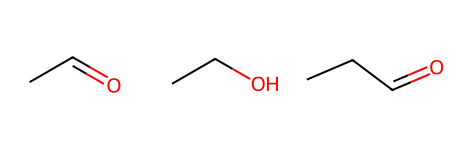
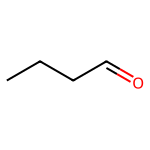
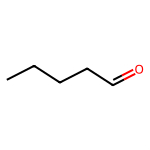
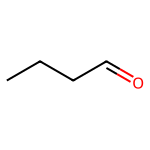
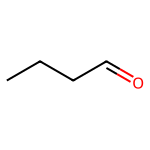
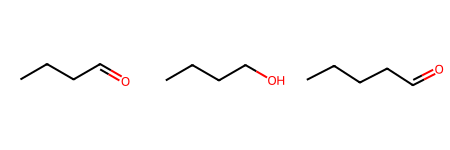
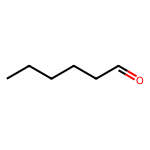
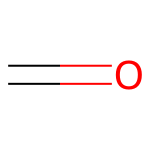
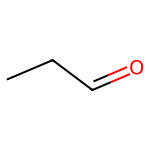
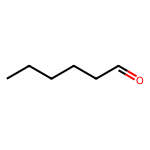
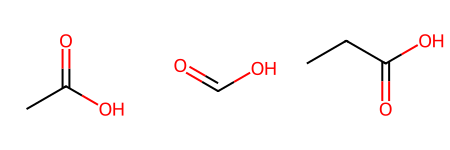
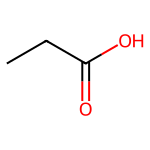
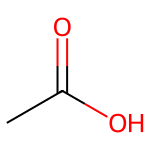
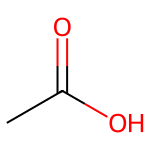
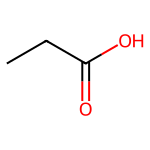
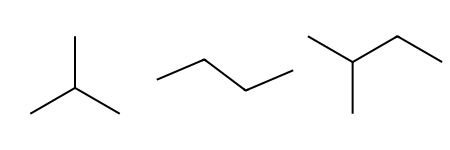
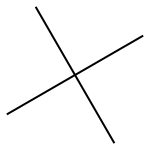
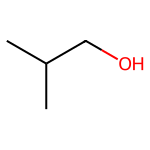
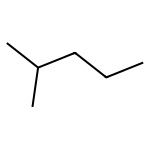
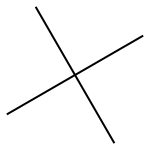
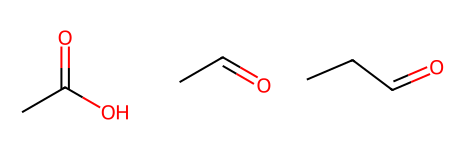
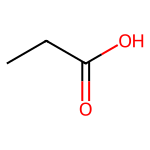
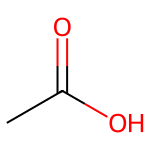
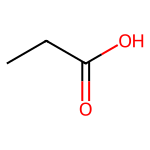
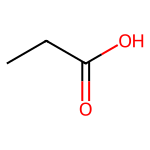
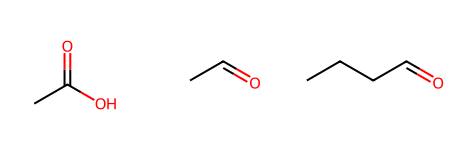
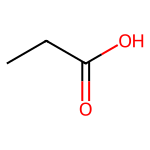
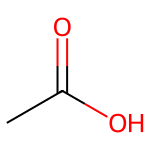
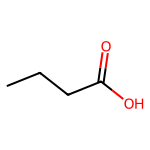
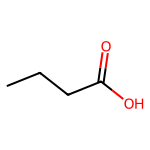
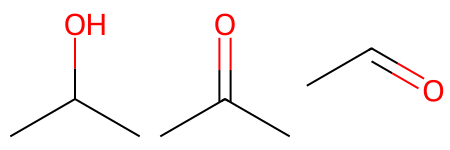
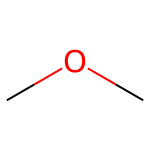
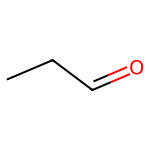
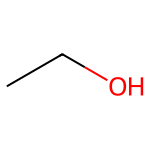
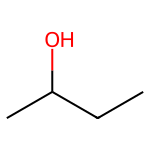
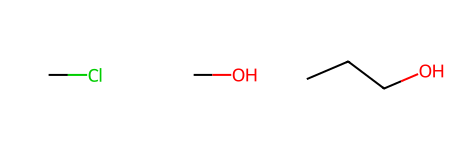
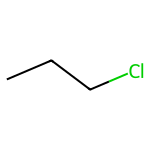
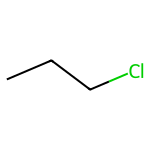
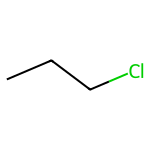
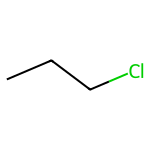
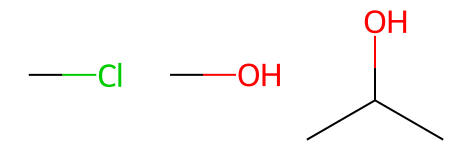
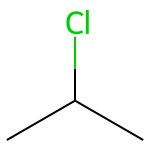
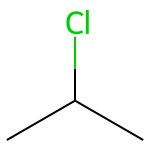
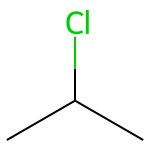
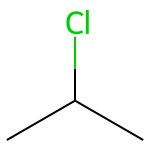
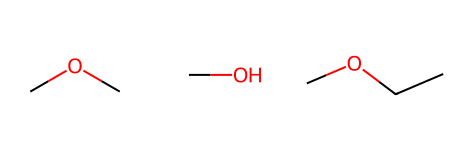
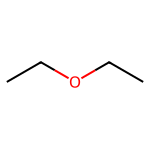
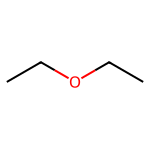
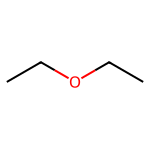
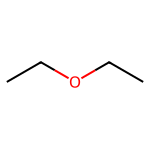

In [285]:
models = [
    ('roberta', 'selfies_atom_standard'),
    ('roberta', 'smiles_atom_standard'),
    ('bart', 'selfies_atom_standard'),
    ('bart', 'smiles_atom_standard'),
]

rows = evaluate_operations(operations, embedding_dict, smiles_to_name, models)
display_results(rows, models)


In [154]:
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
import numpy as np
import re
from html import escape

# --- helpers you already have / need ---
def cosine_similarity(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-12))

# isotropy_adjust should exist in your environment, otherwise define a no-op:
# def isotropy_adjust(emb_dict, remove_topk=1): return emb_dict

# ---- RDKit SVG helpers ----
def mol_to_svg_scaled(smiles, size=(180, 180), bond_length=30):
    """Return RDKit SVG string for a SMILES at fixed bond scale (consistent sizing)."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        # minimal placeholder tile
        w, h = size
        return f"<svg width='{w}' height='{h}' xmlns='http://www.w3.org/2000/svg'>" \
               f"<rect x='0' y='0' width='{w}' height='{h}' fill='white' stroke='red'/>" \
               f"<text x='{w/2}' y='{h/2}' text-anchor='middle' font-size='14' fill='red'>Invalid</text></svg>"
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    # consistent scale across molecules:
    drawer.drawOptions().fixedBondLength = bond_length
    # (optional) make lines a bit bolder for print
    drawer.drawOptions().bondLineWidth = 2
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # strip XML header to safely nest
    svg = re.sub(r"^\s*<\?xml[^>]*>\s*", "", svg)
    return svg

def svg_inner(svg):
    """Return inner content of an RDKit SVG (strip outer <svg> ... </svg>)."""
    m_open = re.search(r"<svg[^>]*>", svg, flags=re.IGNORECASE | re.DOTALL)
    m_close = re.search(r"</svg>", svg, flags=re.IGNORECASE)
    if not m_open or not m_close:
        return svg  # fallback
    return svg[m_open.end():m_close.start()]

def svg_rect(x, y, w, h, stroke="none", fill="none", stroke_width=2, rx=8, ry=8):
    return (f"<rect x='{x}' y='{y}' width='{w}' height='{h}' "
            f"fill='{fill}' stroke='{stroke}' stroke-width='{stroke_width}' rx='{rx}' ry='{ry}'/>")

def svg_text(x, y, text, size=14, anchor="middle", weight="normal", fill="#000"):
    t = escape(str(text))
    return (f"<text x='{x}' y='{y}' font-size='{size}' text-anchor='{anchor}' "
            f"font-weight='{weight}' fill='{fill}' font-family='Arial, Helvetica, sans-serif'>{t}</text>")

# ---- Main function: evaluate + render to one big SVG ----
def evaluate_operations_to_svg(
    operations, embeddings_dict, smiles_to_name, models,
    outfile="results.svg",
    tile_size=(180, 180),         # molecule tile (drawing) size
    caption_h=28,                 # text space under each tile
    row_gap=24, col_gap=40,       # gaps between rows/columns
    symbol_gap=16,                # space around '+' and '?'
    margin=(30, 50, 30, 30),      # (left, top, right, bottom) margins
    bond_length=30,               # fixed bond length for consistent scale
    show_headers=True
):
    """
    - operations: list of (A, B, C, expected) using NAMES (not SMILES)
    - embeddings_dict: dict[model][rep] -> ndarray [N x D] aligned with smiles_to_name.values() order
    - smiles_to_name: dict[SMILES] -> NAME
    - models: list of (model_key, rep_key)
    - writes a single SVG file (outfile) with rows=operations, columns=[equation] + [predictions per model]
    """
    # Reverse map name -> SMILES
    name_to_smiles = {v: k for k, v in smiles_to_name.items()}

    # Prepare evaluation results for all rows/models
    # Each row_data: {"op": (A,B,C,expected, SA,SB,SC,SEXP), "preds": { (model,rep): (pred_smiles, pred_name, score, correct) } }
    rows_data = []
    all_names = list(smiles_to_name.values())

    for (A, B, C, EXPECTED) in operations:
        SA, SB, SC, SEXP = name_to_smiles[A], name_to_smiles[B], name_to_smiles[C], name_to_smiles[EXPECTED]
        row_entry = {"op": (A, B, C, EXPECTED, SA, SB, SC, SEXP), "preds": {}}

        for (model_key, rep_key) in models:
            # embeddings array aligned with all_names by index
            X = embeddings_dict[model_key][rep_key]  # shape (N, D)
            # map name -> vector
            emb_dict = {name: X[i] for i, name in enumerate(all_names)}
            # isotropy adjust (your function)
            #emb_dict = isotropy_adjust(emb_dict, remove_topk=0)
            
            
            
            va, vb, vc = emb_dict[A], emb_dict[B], emb_dict[C]
            query = va - vb + vc

            # NN search over NAME keys (exclude A,B,C)
            best_name, best_score = None, -1.0
            for name, vec in emb_dict.items():
                if name in (A, B, C):  # skip the operands
                    continue
                score = cosine_similarity(query, vec)
                if score > best_score:
                    best_score = score
                    best_name = name

            pred_smiles = name_to_smiles.get(best_name, best_name)  # fallback to name if unseen
            correct = (pred_smiles == SEXP)
            row_entry["preds"][(model_key, rep_key)] = (pred_smiles, best_name, best_score, correct)

        rows_data.append(row_entry)

    # ---- Layout calculations ----
    n_rows = len(rows_data)
    n_models = len(models)
    tile_w, tile_h = tile_size
    cell_h = tile_h + caption_h
    # first column (equation) uses 3 tiles + 2 symbol gaps (+/?); also extra space for symbols between tiles
    eqn_width = 3 * tile_w + 2 * symbol_gap
    # total width: margins + eqn col + gaps + model columns
    total_w = (margin[0] + eqn_width +
               (col_gap if n_models > 0 else 0) +
               n_models * tile_w +
               (n_models - 1) * col_gap +
               margin[2])
    # total height
    total_h = (margin[1] +
               n_rows * cell_h +
               (n_rows - 1) * row_gap +
               margin[3] +
               (30 if show_headers else 0))

    # ---- Build SVG ----
    svg_parts = [f"<svg xmlns='http://www.w3.org/2000/svg' width='{total_w}' height='{total_h}'>"]
    # background
    svg_parts.append(svg_rect(0, 0, total_w, total_h, fill="white", stroke="none"))

    # Column headers
    start_y = margin[1] + (30 if show_headers else 0)
    if show_headers:
        # First column title:
        svg_parts.append(svg_text(margin[0] + eqn_width / 2, margin[1], "A - B + C", size=16, weight="bold"))
        # Model headers:
        for j, (model_key, rep_key) in enumerate(models):
            x = margin[0] + eqn_width + col_gap + j * (tile_w + col_gap) + tile_w / 2
            svg_parts.append(svg_text(x, margin[1], f"{model_key} | {rep_key}", size=14))

    # Draw each row
    for i, row in enumerate(rows_data):
        (A, B, C, EXPECTED, SA, SB, SC, SEXP) = row["op"]
        y0 = start_y + i * (cell_h + row_gap)
        # ---- Equation column: A ? B + C (three tiles + symbols)
        # positions of three tiles inside equation column
        xA = margin[0]
        xB = margin[0] + tile_w + symbol_gap
        xC = margin[0] + 2 * (tile_w + symbol_gap)

        # tiles (SVG molecules)
        svgA = mol_to_svg_scaled(SA, size=tile_size, bond_length=bond_length)
        svgB = mol_to_svg_scaled(SB, size=tile_size, bond_length=bond_length)
        svgC = mol_to_svg_scaled(SC, size=tile_size, bond_length=bond_length)

        # place tiles by translating inner content
        svg_parts.append(f"<g transform='translate({xA},{y0})'>{svg_inner(svgA)}</g>")
        svg_parts.append(f"<g transform='translate({xB},{y0})'>{svg_inner(svgB)}</g>")
        svg_parts.append(f"<g transform='translate({xC},{y0})'>{svg_inner(svgC)}</g>")

        # symbols between tiles
        mid_y = y0 + tile_h / 2 + 5
        svg_parts.append(svg_text(xA + tile_w + symbol_gap / 2, mid_y, "-", size=22, weight="bold"))
        svg_parts.append(svg_text(xB + tile_w + symbol_gap / 2, mid_y, "+", size=22, weight="bold"))

        # captions under A, B, C
        svg_parts.append(svg_text(xA + tile_w / 2, y0 + tile_h + 18, A, size=12))
        svg_parts.append(svg_text(xB + tile_w / 2, y0 + tile_h + 18, B, size=12))
        svg_parts.append(svg_text(xC + tile_w / 2, y0 + tile_h + 18, C, size=12))

        # ---- Prediction columns
        for j, (model_key, rep_key) in enumerate(models):
            x = margin[0] + eqn_width + col_gap + j * (tile_w + col_gap)
            pred_smiles, pred_name, score, correct = row["preds"][(model_key, rep_key)]
            svgP = mol_to_svg_scaled(pred_smiles, size=tile_size, bond_length=bond_length)
            # tile
            svg_parts.append(f"<g transform='translate({x},{y0})'>{svg_inner(svgP)}</g>")
            # border highlight
            border_color = "#2ecc71" if correct else "#cccccc"
            svg_parts.append(svg_rect(x, y0, tile_w, tile_h, stroke=border_color, stroke_width=4, fill="none", rx=10, ry=10))
            # caption: name + similarity
            label = f"{pred_name}  (cos={score:.3f})"
            svg_parts.append(svg_text(x + tile_w / 2, y0 + tile_h + 18, label, size=12))

    svg_parts.append("</svg>")
    svg = "\n".join(svg_parts)

    # write file
    with open(outfile, "w", encoding="utf-8") as f:
        f.write(svg)
    print(f"? Wrote SVG to {outfile}")

    return svg  # also return the SVG string if you want to display inline


In [155]:
models = [
    ('roberta', 'selfies_atom_standard'),
    ('roberta', 'smiles_atom_standard'),
    ('bart', 'selfies_atom_standard'),
    ('bart', 'smiles_atom_standard'),
]

# operations: list of (A, B, C, expected) using NAMES (not SMILES)
# embeddings_dict: your dict as described
# smiles_to_name: SMILES->NAME dictionary

svg = evaluate_operations_to_svg(
    operations, embedding_dict, smiles_to_name,
    models=models,
    outfile="analogy_results.svg",
    bond_length=30,         # constant scale across all drawings
    tile_size=(180,180),
    show_headers=True
)


? Wrote SVG to analogy_results.svg
